In [2]:
using Catalyst
using ColorSchemes
using Dictionaries
using DifferentialEquations
using Formatting
using IterTools
using LaTeXStrings
using LinearAlgebra
using NNlib
using Noise
using Plots
using Random
using ReactionNetworkImporters
using Statistics

include("utils.jl")
include("datasets.jl")
Random.seed!(1224)

TaskLocalRNG()

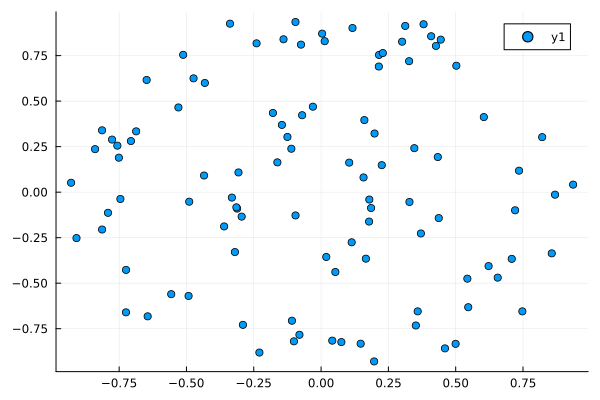

In [3]:
train = create_annular_rings_dataset(100)
val = create_annular_rings_dataset(50)

x = getindex.(train, 1)
y = getindex.(train, 2)
labels = getindex.(train, 3)

scatter(x, y)

In [148]:
function create_params(; dims=3, t0=0.0, t1=1.0, h=0.1)
    params = []

    push!(params, Float32(dims))

    theta = rand(Normal(1, 0.2), dims^2)
    append!(params, theta)
    beta = ones(dims)*0.1
    for i in eachindex(beta)
        beta[i] = abs(beta[i])
    end
    append!(params, beta)

    w = randn(dims)
    append!(params, w)

    push!(params, h)

    push!(params, t0)
    push!(params, t1)

    for i in eachindex(params)
        params = 1.0 * params
    end

    return params
end

params = create_params(h=0.5)

19-element Vector{Float64}:
  3.0
  1.1076834308115338
  1.0334615832535865
  0.793824265698868
  0.962984499270744
  0.818022538600324
  0.9268619649386434
  1.107753236809595
  1.0151265416418471
  0.8315771300156235
  0.1
  0.1
  0.1
  0.0417297121102912
  0.3208711454328557
 -1.4370814490904378
  0.5
  0.0
  1.0

In [149]:
function f(u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    hvec = [h, h, h]
    fmat = hvec + (theta * x + beta) .* u - u .* u
    # fmat = theta*u
    @assert length(fmat) == length(u)
    return fmat
end

function forward!(du, u, xAndp, t)
    fmat = f(u, xAndp, t)
    for i in eachindex(fmat)
        du[i] = fmat[i] 
    end
end

# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-12, save_on=false)
    return sol
end

forward_node (generic function with 1 method)

In [150]:
function backward!(du, u, sAndp, t)
    func = -f(u, sAndp, t)
    for i in eachindex(func)
        du[i] = func[i]
    end
end

function backward_node(s0, sAndp, tspan)
    prob = ODEProblem(backward!, s0, tspan, sAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-12, save_on=false)
    return sol
end

backward_node (generic function with 1 method)

In [153]:
DIMS = 3
tspan = (0.0, 0.2)
rtspan = reverse(tspan)
fsol = nothing
bsol = nothing
fwd_diff_perc = 0.0
bwd_diff_perc = 0.0
for trindex in eachindex(train)
    x = train[trindex][1:2]
    y = train[trindex][3]
    append!(x, 0.0)

    println("ODE | Input | ", x)
    dims, theta, beta, w, h, t0, t1 = sequester_params(params)
    reluval = relu.(x + theta*x + beta)
    # relualt = x + relu.(theta*x + beta)
    println("ODE | Ideal Before ReLU | ",  x + theta*x + beta)
    println("ODE | Ideal ReLU | Val1 | ", reluval)
    # println("ODE | Ideal ReLU | Val2 | ", relualt)

    xAndp = []
    append!(xAndp, x)
    append!(xAndp, params)

    fsol = forward_node(x, xAndp, tspan)
    println("ODE | z @ t=T | ", fsol[end])
    z = fsol[end]

    zAndp = []
    append!(zAndp, z)
    append!(zAndp, params)
    bsol = backward_node(z, zAndp, tspan)
    println("ODE | Input | ", x)
    println("ODE | z @ t=0 | ", bsol[end])
    println("===========================")
    # break
end

ODE | Input | Float32[-0.644075, -0.6821511, 0.0]
ODE | Ideal Before ReLU | [-1.962483090357153, -1.7604002553598541, -1.3059458057872466]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.46005455, -0.5252741, 0.08749551]
ODE | Input | Float32[-0.644075, -0.6821511, 0.0]
ODE | z @ t=0 | Float32[-0.5971918, -0.6377828, -0.004519888]
ODE | Input | Float32[-0.3118192, -0.09033434, 0.0]
ODE | Ideal Before ReLU | [-0.6505732232853932, -0.3645069199001111, -0.33711951048827116]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.20791064, 0.011334114, 0.09608478]
ODE | Input | Float32[-0.3118192, -0.09033434, 0.0]
ODE | z @ t=0 | Float32[-0.29709902, -0.08821757, -0.002949698]
ODE | Input | Float32[0.38066703, 0.92237866, 0.0]
ODE | Ideal Before ReLU | [1.8555685030433438, 2.1434816416921625, 1.4580161939749499]
ODE | Ideal ReLU | Val1 | [1.8555685030433438, 2.1434816416921625, 1.4580161939749499]
ODE | z @ t=T | Float32[0.57515323, 1.0668024, 0.11521887]

, 0.8346694, -0.0037182495]
ODE | Input | Float32[0.013465843, 0.8292968, 0.0]
ODE | Ideal Before ReLU | [0.9854281466629328, 1.6206477214867403, 0.9567580516587963]
ODE | Ideal ReLU | Val1 | [0.9854281466629328, 1.6206477214867403, 0.9567580516587963]
ODE | z @ t=T | Float32[0.1255407, 0.9148372, 0.1094064]
ODE | Input | Float32[0.013465843, 0.8292968, 0.0]
ODE | z @ t=0 | Float32[0.00995436, 0.77732944, -0.0027428442]
ODE | Input | Float32[0.3464005, 0.24156666, 0.0]
ODE | Ideal Before ReLU | [1.0797524537505678, 0.8727519402625465, 0.7289470005124754]
ODE | Ideal ReLU | Val1 | [1.0797524537505678, 0.8727519402625465, 0.7289470005124754]
ODE | z @ t=T | Float32[0.47265425, 0.36120677, 0.1068914]
ODE | Input | Float32[0.3464005, 0.24156666, 0.0]
ODE | z @ t=0 | Float32[0.31880152, 0.22316305, -0.00320724]
ODE | Input | Float32[0.053022064, -0.43855995, 0.0]
ODE | Ideal Before ReLU | [-0.24148113333018265, -0.6462524465230673, -0.2864584814192007]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0

ODE | z @ t=T | Float32[0.7731068, -0.3237126, 0.104572244]
ODE | Input | Float32[0.7081733, -0.36639437, 0.0]
ODE | z @ t=0 | Float32[0.6763257, -0.35460612, -0.0019155702]
ODE | Input | Float32[0.17832279, -0.16155265, 0.0]
ODE | Ideal Before ReLU | [0.30888953389127594, -0.021984279195582684, 0.133541264448576]
ODE | Ideal ReLU | Val1 | [0.30888953389127594, 0.0, 0.133541264448576]
ODE | z @ t=T | Float32[0.27381936, -0.06756535, 0.10066813]
ODE | Input | Float32[0.17832279, -0.16155265, 0.0]
ODE | z @ t=0 | Float32[0.16550441, -0.15584922, -0.002736299]
ODE | Input | Float32[-0.29030713, -0.72877944, 0.0]
ODE | Ideal Before ReLU | [-1.265041085900731, -1.5044987092304105, -0.9613920154207166]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.15712436, -0.6151753, 0.09042672]
ODE | Input | Float32[-0.29030713, -0.72877944, 0.0]
ODE | z @ t=0 | Float32[-0.27511138, -0.6910757, -0.003469221]
ODE | Input | Float32[0.2254207, 0.14831229, 0.0]
ODE | Ideal Before ReLU |

ODE | z @ t=T | Float32[0.60169744, -0.43854925, 0.101536624]
ODE | Input | Float32[0.5433472, -0.47519088, 0.0]
ODE | z @ t=0 | Float32[0.5207341, -0.46068326, -0.0018024729]
ODE | Input | Float32[-0.12495949, 0.3032802, 0.0]
ODE | Ideal Before ReLU | [0.15005339123698094, 0.5310361942991912, 0.26944350433811803]
ODE | Ideal ReLU | Val1 | [0.15005339123698094, 0.5310361942991912, 0.26944350433811803]
ODE | z @ t=T | Float32[-0.030656844, 0.39461553, 0.10204552]
ODE | Input | Float32[-0.12495949, 0.3032802, 0.0]
ODE | z @ t=0 | Float32[-0.120818615, 0.28476372, -0.0026856633]
ODE | Input | Float32[-0.13953133, 0.83970654, 0.0]
ODE | Ideal Before ReLU | [0.6737165796178305, 1.4922389084722698, 0.7978421144137824]
ODE | Ideal ReLU | Val1 | [0.6737165796178305, 1.4922389084722698, 0.7978421144137824]
ODE | z @ t=T | Float32[-0.05792895, 0.90143514, 0.10764392]
ODE | Input | Float32[-0.13953133, 0.83970654, 0.0]
ODE | z @ t=0 | Float32[-0.13522603, 0.796337, -0.0022435968]
ODE | Input | Fl

ODE | Input | Float32[-0.7763634, 0.28883243, 0.0]
ODE | z @ t=0 | Float32[-0.7505741, 0.27593097, -0.0019883171]
ODE | Input | Float32[0.37075338, -0.22688462, 0.0]
ODE | Ideal Before ReLU | [0.646954214096009, 0.04454840583855901, 0.2803866561490178]
ODE | Ideal ReLU | Val1 | [0.646954214096009, 0.04454840583855901, 0.2803866561490178]
ODE | z @ t=T | Float32[0.45902494, -0.14406219, 0.10215752]
ODE | Input | Float32[0.37075338, -0.22688462, 0.0]
ODE | z @ t=0 | Float32[0.34819284, -0.21840082, -0.0025439963]
ODE | Input | Float32[0.5023934, 0.69442564, 0.0]
ODE | Ideal Before ReLU | [1.876548520530411, 1.8462785497691316, 1.3614578430425526]
ODE | Ideal ReLU | Val1 | [1.876548520530411, 1.8462785497691316, 1.3614578430425526]
ODE | z @ t=T | Float32[0.69460166, 0.8524614, 0.114068456]
ODE | Input | Float32[0.5023934, 0.69442564, 0.0]
ODE | z @ t=0 | Float32[0.45073396, 0.6301414, -0.0040546805]
ODE | Input | Float32[-0.83939487, 0.23628002, 0.0]
ODE | Ideal Before ReLU | [-1.4249923

ODE | Input | Float32[-0.0702905, 0.42265397, 0.0]
ODE | z @ t=0 | Float32[-0.06905252, 0.39712888, -0.002701929]
ODE | Input | Float32[0.43706354, -0.14237249, 0.0]
ODE | Ideal Before ReLU | [0.8740550941158917, 0.26204902518624384, 0.43963246429396674]
ODE | Ideal ReLU | Val1 | [0.8740550941158917, 0.26204902518624384, 0.43963246429396674]
ODE | z @ t=T | Float32[0.53220445, -0.052388784, 0.103805825]
ODE | Input | Float32[0.43706354, -0.14237249, 0.0]
ODE | z @ t=0 | Float32[0.4092184, -0.13760325, -0.0026651816]
ODE | Input | Float32[-0.22908399, -0.8810349, 0.0]
ODE | Ideal Before ReLU | [-1.2933522533308688, -1.7223456515809836, -1.0481304479281401]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.09998824, -0.7796093, 0.089676425]
ODE | Input | Float32[-0.22908399, -0.8810349, 0.0]
ODE | z @ t=0 | Float32[-0.21833938, -0.8376523, -0.00331689]
ODE | Input | Float32[-0.17881896, 0.43499443, 0.0]
ODE | Ideal Before ReLU | [0.17265628094934835, 0.7186297939030794

ODE | z @ t=T | Float32[-0.6447738, 0.33946997, 0.09551778]
ODE | Input | Float32[-0.70624995, 0.2806783, 0.0]
ODE | z @ t=0 | Float32[-0.68151504, 0.26750556, -0.0020832156]
ODE | Input | Float32[0.019251993, -0.35587707, 0.0]
ODE | Ideal Before ReLU | [-0.22720817537882235, -0.5284531664066757, -0.2399338034834441]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[0.114848964, -0.26461986, 0.09700803]
ODE | Input | Float32[0.019251993, -0.35587707, 0.0]
ODE | z @ t=0 | Float32[0.015465486, -0.3409742, -0.0027508214]
ODE | Input | Float32[-0.10827491, -0.70622945, 0.0]
ODE | Ideal Before ReLU | [-0.8580702309898904, -1.2882081114456312, -0.7368541360317716]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.0010167737, -0.61706865, 0.092408836]
ODE | Input | Float32[-0.10827491, -0.70622945, 0.0]
ODE | z @ t=0 | Float32[-0.10516978, -0.6747439, -0.0029125463]
ODE | Input | Float32[0.17921825, -0.0405786, 0.0]
ODE | Ideal Before ReLU | [0.4357989066019

ODE | z @ t=T | Float32[-0.34110552, -0.43654406, 0.08988428]
ODE | Input | Float32[-0.49218258, -0.570161, 0.0]
ODE | z @ t=0 | Float32[-0.46142974, -0.53777033, -0.003872345]
ODE | Input | Float32[-0.36009333, -0.18826225, 0.0]
ODE | Ideal Before ReLU | [-0.8535245425273271, -0.5890293115676081, -0.490004557563785]
ODE | Ideal ReLU | Val1 | [0.0, 0.0, 0.0]
ODE | z @ t=T | Float32[-0.24879792, -0.0812896, 0.09465605]
ODE | Input | Float32[-0.36009333, -0.18826225, 0.0]
ODE | z @ t=0 | Float32[-0.34204507, -0.18078509, -0.0030986655]
ODE | Input | Float32[0.3282868, -0.05386581, 0.0]
ODE | Ideal Before ReLU | [0.7362563979411877, 0.3182058418313174, 0.40898014936979366]
ODE | Ideal ReLU | Val1 | [0.7362563979411877, 0.3182058418313174, 0.40898014936979366]
ODE | z @ t=T | Float32[0.43024832, 0.04561035, 0.103485845]
ODE | Input | Float32[0.3282868, -0.05386581, 0.0]
ODE | z @ t=0 | Float32[0.30564076, -0.053564686, -0.002823834]
ODE | Input | Float32[-0.16230154, 0.16368458, 0.0]
ODE |

In [154]:
params

19-element Vector{Float64}:
  3.0
  1.1076834308115338
  1.0334615832535865
  0.793824265698868
  0.962984499270744
  0.818022538600324
  0.9268619649386434
  1.107753236809595
  1.0151265416418471
  0.8315771300156235
  0.1
  0.1
  0.1
  0.0417297121102912
  0.3208711454328557
 -1.4370814490904378
  0.5
  0.0
  1.0

ODESolution{Float32, 2, Vector{Vector{Float32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float32}}}, ODEProblem{Vector{Float32}, Tuple{Float64, Float64}, true, Vector{Any}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float32}, Vector{Float32}, Vector{Any}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{Any}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{Float32}, Vector{Any}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Ta

{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{Any}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}(ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float32}, Vector{Float32}, Vector{Any}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{Any}, Float64}}, FunctionWrappers.Func

}}, Vector{Float32}, Vector{Any}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}(Ptr{Nothing} @0x00000002e2db4110, Ptr{Nothing} @0x00000002d9ec4960, Base.RefValue{SciMLBase.Void{typeof(forward!)}}(SciMLBase.Void{typeof(forward!)}(forward!)), SciMLBase.Void{typeof(forward!)}), FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float32}, Float32, 1}}, Vector{Any}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}(Ptr{Nothing} @0x00000002e2dd4110, Ptr{Nothing} @0x00000002d9ec4968, Base.RefValue{SciMLBase.Void{typeof(forward!)}}(SciMLBase.Void{typeof(forward!)}(forward!)), SciMLBase.Void{typeof(forward!)}))), UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, SciMLBase.DEFAULT_OBSE

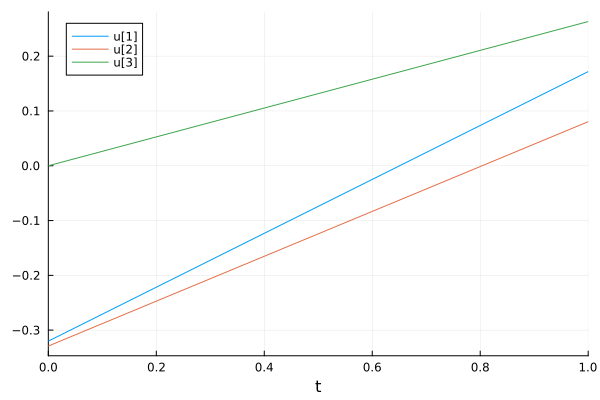

In [100]:
print(fsol)
plot(fsol)

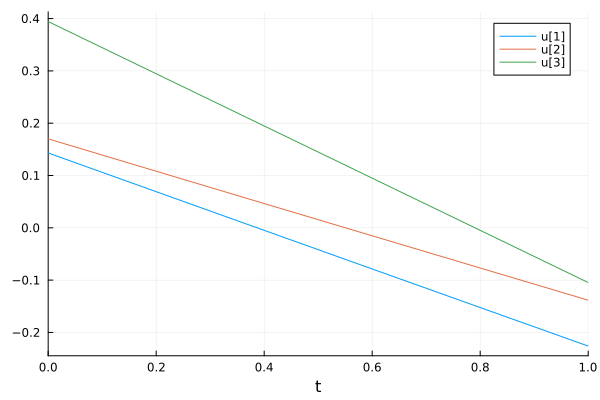

In [101]:
plot(bsol)

In [12]:
params

19-element Vector{Float64}:
  3.0
  1.5634401959304427
  0.5458121674020318
 -0.1193719599987977
  0.8709207321916447
 -0.15329268821160216
  2.07717697154939
 -0.48212240657980276
 -0.126640066202947
  1.4142791871763898
  0.06405547942899233
 -1.2226870977249997
  0.054503795866502024
 -0.5059535133708911
 -2.105702918223307
  0.2038829682672081
  0.1
  0.0
  1.0

In [13]:
a = [1, 2, 3]
b = [2, 4, 6]
a./b

3-element Vector{Float64}:
 0.5
 0.5
 0.5

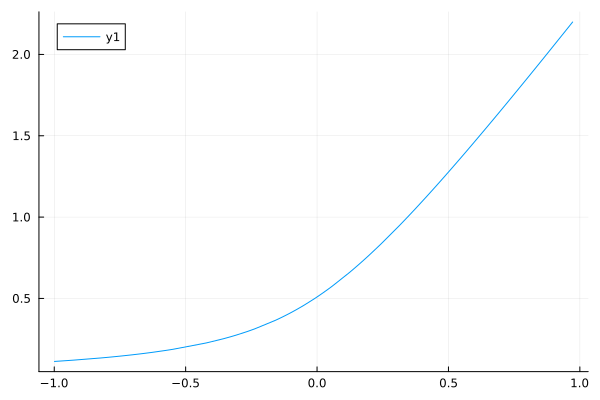

In [212]:
dims, theta, beta, w, h, _, _ = sequester_params(params)
index = 2
xplot = sort!(rand(Uniform(-1, 1), 100))
yplot = []
for i in eachindex(xplot)
    x = zeros(dims)
    x[index] = xplot[i]
    rho = theta*x + beta
    rhoindex = rho[index]
    push!(yplot, (rhoindex + sqrt(rhoindex^2 + 1))/2)
end
plot(xplot, yplot)
